### Crawling 

**headers**

- referer
- user-agent
- language 

보안 있는 사이트는 보통 이 3가지 중에서 설정한다.
요청값을 많이 둘 수록 서버에 부담이 되므로 보통 1~2개만 설정한다.

In [1]:
# -*- coding:utf-8 -*-

import requests, bs4, re

head = { 
    'Accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
    'Accept-Encoding' : 'gzip, deflate, br',
    'Accept-Language' : 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
    'Content-Type': 'application/x-www-form-urlencoded',
    'Host': 'startag.io',
    'Referer':'https://startag.io/',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent' : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36",
} 

query_keyword = "인테리어"

# 누적게시물 내림차순으로, 해시태그 정보 가져오기 
url = f"https://startag.io/search.php?q={query_keyword}&mode=0&order=total_cnt&order_asc=desc"

res = requests.get(url, headers=head)

html = res.text

soup = bs4.BeautifulSoup(html, 'html.parser')

### 인스타그램 타이틀 

In [2]:
titles = soup.find_all("td", class_="result_td01" )

keywords = [t.get("title")[1:] for t in titles[1:]] # title의 속성값 가져옴
keywords[:5]

['인테리어', '인테리어소품', '셀프인테리어', '홈인테리어', '카페인테리어']

### 누적게시물 수, 인기글 평균 좋아요 수, 인기글 평균 유지시간(h), 게시물 생산지수, 반응도, 트렌드 지수

**지표설명**

1. 누적 게시물 수
현재까지 해당 해시태그를 포함하여 업로드된 게시물의 총개수입니다. 

<br>

2. 인기글 평균 좋아요 수
해당 태그에서 인기 게시물에 오르기 위해 필요한 게시글의 평균적인 좋아요 수입니다. (인기 게시물은 게시물 업로더에 대한 팔로우 여부에 따라 개인마다 편차가 존재합니다.)

<br>

3. 인기글 평균 체류시간
인기 게시물에 올라가고 난 뒤 유지되는 평균 시간입니다. (인기 게시물은 게시물 업로더에 대한 팔로우 여부에 따라 개인마다 편차가 존재합니다.)

<br>

4. 게시물 생산지수
해당 태그가 포함된 게시물이 1분 동안 얼마나 빨리 올라오는지를 나타내는 지표입니다. (수집 날짜와 시간에 따른 편차가 있습니다.)

<br>

5. 반응도
해당 태그에 대한 조회 수, 생산지수, 좋아요 수, 댓글 수 등에 비례하여 얼마나 고객 반응을 이끌어 내는지가 합산된 수치입니다.

<br>

6. 트렌드지수
게시물의 반응도에 비례하며, 반응도의 증감 추이에 따라 수치가 결정됩니다. 오래되거나 반응이 저조한 해시태그는 트렌드 지수가 낮으며, 새로 등장하였거나 반응이 높은 해시태그는 트렌드 지수가 높습니다. 평균 이상과 이하의 기준은 1.00은 기준으로 합니다.

In [3]:
# 누적 게시물 수 
total_nums = soup.find_all("td", class_="result_td02" )

total_cnt = [ int(t.getText().replace(",","")) for t in total_nums[1:] ]
total_cnt[:5]

[6980309, 1696425, 993264, 668397, 649570]

In [4]:
# 평균 좋아요 수 
good_avgs = soup.find_all("td", class_="result_td03" )

hearts_avgs = [ int(g.getText().replace(",","")) for g in good_avgs[1:] ]
hearts_avgs[:5]

[328, 326, 1139, 784, 364]

In [5]:
# 게시물 생산지수 
producivity_pnt = soup.find_all("td", class_="result_td05")
productivities = [float(p.getText()) for p in producivity_pnt[1:]]
productivities[:5]

[0.0, 0.6, 0.79, 0.32, 1.4]

In [6]:
# 반응도 
reaction_pnt = soup.find_all("td", class_="result_td06")

reactions = [ int(r.getText()) for r in reaction_pnt[1:] ]
reactions[:5]

[0, 20, 27, 9, 42]

### List 병합

In [7]:
results = list(zip(keywords, total_cnt, hearts_avgs, productivities, reactions))
results[:5]

[('인테리어', 6980309, 328, 0.0, 0),
 ('인테리어소품', 1696425, 326, 0.6, 20),
 ('셀프인테리어', 993264, 1139, 0.79, 27),
 ('홈인테리어', 668397, 784, 0.32, 9),
 ('카페인테리어', 649570, 364, 1.4, 42)]

In [8]:
import pandas as pd

In [9]:
df = pd.DataFrame(results)
df.columns = ["태그","누적게시물 수", "인기글 평균 좋아요 수", "게시물 생산지수","반응도"]
df.head()

,태그,누적게시물 수,인기글 평균 좋아요 수,게시물 생산지수,반응도
0,인테리어,6980309,328,0.00,0
1,인테리어소품,1696425,326,0.60,20
2,셀프인테리어,993264,1139,0.79,27
3,홈인테리어,668397,784,0.32,9
4,카페인테리어,649570,364,1.40,42


In [10]:
df.sort_values("인기글 평균 좋아요 수", ascending=False).head()

,태그,누적게시물 수,인기글 평균 좋아요 수,게시물 생산지수,반응도
64,인테리어견적,25605,2647,0.04,6
44,미용실인테리어,44327,1865,0.06,10
38,모던인테리어,58707,1817,0.04,3
65,인테리어공사,25021,1781,0.02,4
29,사무실인테리어,75669,1736,0.07,6


### 함수로 만들기 

In [11]:
def crawl_tags(query_keyword) :
    """
    method : 인스타그램 해시태그 정보 크롤링 
    param : query_keyword에 여러단어를 지정할 수 있다. 예를 들어, "신혼+인테리어"
    return : 누적게시물 기준 내림차순으로 정렬된 데이터프레임 반환
    """

    import requests, bs4, re
    import pandas as pd
    
    HEADER = { 
        'Accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
        'Accept-Encoding' : 'gzip, deflate, br',
        'Accept-Language' : 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
        'Content-Type': 'application/x-www-form-urlencoded',
        'Host': 'startag.io',
        'Referer':'https://startag.io/',
        'Upgrade-Insecure-Requests': '1',
        'User-Agent' : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36",
    } 
    
    url = f"https://startag.io/search.php?q={query_keyword}&mode=0&order=total_cnt&order_asc=desc"
    res = requests.get(url, headers=HEADER)

    html = res.text
    soup = bs4.BeautifulSoup(html, 'html.parser')
    
    # 인스타그램 타이틀 
    titles = soup.find_all("td", class_="result_td01" )
    keywords = [t.get("title")[1:] for t in titles[1:]] # title의 속성값 가져옴
    
    # 누적 게시물 수 
    total_nums = soup.find_all("td", class_="result_td02" )
    total_cnt = [ int(t.getText().replace(",","")) for t in total_nums[1:] ]

    # 평균 좋아요 수 
    good_avgs = soup.find_all("td", class_="result_td03" )
    hearts_avgs = [ int(g.getText().replace(",","")) for g in good_avgs[1:] ]

    # 게시물 생산지수 
    producivity_pnt = soup.find_all("td", class_="result_td05")
    productivities = [float(p.getText()) for p in producivity_pnt[1:]]

    # 반응도 
    reaction_pnt = soup.find_all("td", class_="result_td06")
    reactions = [ int(r.getText()) for r in reaction_pnt[1:] ]

    # 리스트 병합
    results = list(zip(keywords, total_cnt, hearts_avgs, productivities, reactions))

    df = pd.DataFrame(results)
    df.columns = ["태그","누적게시물 수", "인기글 평균 좋아요 수", "게시물 생산지수","반응도"]
    
    return df

In [12]:
df = crawl_tags("인테리어 자취")
df.head(10)

,태그,누적게시물 수,인기글 평균 좋아요 수,게시물 생산지수,반응도
0,인테리어,6980309,328,0.00,0
1,인테리어소품,1696425,326,0.60,20
2,셀프인테리어,993264,1139,0.79,27
3,홈인테리어,668397,784,0.32,9
4,카페인테리어,649570,364,1.40,42
5,신혼집인테리어,581272,624,1.17,49
6,인테리어디자인,477971,176,0.23,12
7,거실인테리어,409214,754,0.36,28
8,자취,406047,671,0.23,14
9,아파트인테리어,305972,359,0.57,30


In [13]:
df.sort_values("인기글 평균 좋아요 수", ascending=False).head(10)

,태그,누적게시물 수,인기글 평균 좋아요 수,게시물 생산지수,반응도
74,인테리어견적,25605,2647,0.04,6
53,미용실인테리어,44327,1865,0.06,10
45,모던인테리어,58707,1817,0.04,3
75,인테리어공사,25021,1781,0.02,4
16,자취방,207693,1757,0.09,11
36,사무실인테리어,75669,1736,0.07,6
41,주택인테리어,65196,1656,0.07,6
42,집인테리어,64633,1636,0.06,16
113,자취음식,10337,1526,0.01,3
111,자취방인테리어,15910,1509,0.03,6


### 그래프 

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from tqdm import tqdm
from datetime import datetime
import json
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings("ignore")
%matplotlib inline

from matplotlib import font_manager, rc 

path = "C:/Windows/Fonts/malgun.ttf"

font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)

plt.rcParams['axes.unicode_minus'] = False

In [15]:
df = df.sort_values("인기글 평균 좋아요 수", ascending=False)
df2 = df.set_index("태그")

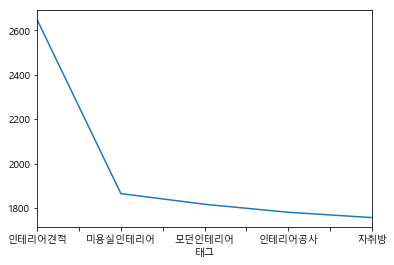

In [16]:
df2[:5]["인기글 평균 좋아요 수"].plot()

In [20]:
# -*- coding:utf-8 -*-

try :
    keyword = "인테리어+앱"
    df = crawl_tags(keyword)
    df = df.sort_values(["누적게시물 수", "게시물 생산지수"], ascending=False)
    df.to_csv(f"{keyword}.csv", encoding="cp949", index=False)
except UnicodeEncodeError :
    print("beep!")